# Seattle Airbnb Data Analysis & Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

## Dataset

<br>link: https://www.kaggle.com/airbnb/seattle/data
<br>
<br>The following Airbnb activity is included in this Seattle dataset:
<br>
* Listings, including full descriptions and average review score
* Reviews, including unique id for each reviewer and detailed comments
* Calendar, including listing id and the price and availability for that day

## Motivation

I want to use Seattle Airbnb data to create price prediction model. This model could be used to help host (especially the new one) to set proper price for their listing. So, after they fill out their listing information, they will get the price recommendation (that the model output). 

Let's do our analysis first of what features that could affect the price of the listings.

## Questions

1. Since the demand at weekend will be higher than weekday, the hosts will put the price higher in the weekend. Could we validate this assumption?
2. Which neighbourhood area has the highest average price? 
3. Is there any correlation between number of listing (at neighbourhood area) and price?
4. Could we create model to predict price of the listing, given: location (neighbourhood), property type, room type, number of accomodated people (accomodates), number of bathrooms, number of bedrooms, number of beds, bed type, and amenities?

## Answers

### 1. Since the demand at weekend will be higher than weekday, the hosts will put the price higher in the weekend. Could we validate this assumption?

In [2]:
df = pd.read_csv('Seattle Airbnb/calendar.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


##### note:
* type of column "date" should be datetime
* type of column "price" should be float

In [4]:
df.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
df.isnull().mean()

listing_id    0.00000
date          0.00000
available     0.00000
price         0.32939
dtype: float64

In [6]:
df["is_price_null"] = df["price"].isnull()
df.groupby("available")["is_price_null"].sum()

available
f    459028.0
t         0.0
Name: is_price_null, dtype: float64

##### note:
* only column "price" that has null value (32.94% is null)
* all of null price value is because of unavailability, so we could ignore it

##### Based on our findings, let's clean and format our data first

In [7]:
df_formatted = df.copy()

# change type of column "date"
df_formatted['date'] = pd.to_datetime(df['date'])

# extract price and change the type
df_formatted["price"] = df_formatted["price"].replace('[\$,]', '', regex=True).astype(float)

# drop any null value
df_formatted = df_formatted.dropna()

#### Add weekday/weekend tag

In [8]:
df_formatted['day_of_week'] = df_formatted['date'].apply(lambda x: x.weekday())
df_formatted['is_weekday'] = df_formatted['day_of_week'].apply(lambda x: True if x<5 else False)

##### Analyze the price difference between weekday and weekend (for each listing)

In [9]:
df_result = df_formatted.groupby(by=['listing_id','is_weekday'])['price'].mean().reset_index()
df_result= df_result.pivot(index='listing_id', columns='is_weekday', values=['price'])
df_result.columns = df_result.columns.get_level_values(1)

In [10]:
has_higher_price_perc = np.sum(df_result[False]>df_result[True]) /df_result.shape[0]
has_higher_price_perc

0.48589846897663175

In [11]:
has_same_price_perc = np.sum(df_result[False]==df_result[True]) /df_result.shape[0]
has_same_price_perc

0.42814934192855225

In [12]:
has_lower_price_perc = np.sum(df_result[False]<df_result[True]) /df_result.shape[0]
has_lower_price_perc

0.08058017727639001

In [13]:
# Calculate average price increased
tmp_df = df_result[df_result[False]>df_result[True]]
np.mean((tmp_df[False]-tmp_df[True]) / tmp_df[True])

0.04422781937186503

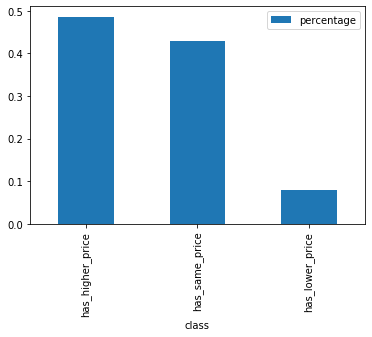

In [14]:
df_plot = pd.DataFrame({'class':['has_higher_price', 'has_same_price', 'has_lower_price'], 
                        'percentage':[has_higher_price_perc, has_same_price_perc, has_lower_price_perc]})
df_plot.plot.bar(x='class', y='percentage');

#### Answer:
Almost <b> 48.6% of listings has higher price on weekend</b>, 42.9% of listings has the same price on weekend, and only 8% of listings has lower price on weekend

On average, price of the listing <b>is increased 4.4% on weekend </b>

### 2. Which neighbourhood area has the highest average price?

In [15]:
df = pd.read_csv('Seattle Airbnb/listings.csv')

In [16]:
# get necessary columns
df = df[["id","neighbourhood_cleansed","price"]]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      3818 non-null   int64 
 1   neighbourhood_cleansed  3818 non-null   object
 2   price                   3818 non-null   object
dtypes: int64(1), object(2)
memory usage: 89.6+ KB


In [18]:
df.head()

,id,neighbourhood_cleansed,price
0,241032,West Queen Anne,$85.00
1,953595,West Queen Anne,$150.00
2,3308979,West Queen Anne,$975.00
3,7421966,West Queen Anne,$100.00
4,278830,West Queen Anne,$450.00


##### note:
* no null value
* we need to extract the price value (same as we did on first question)

##### Based on our findings, let's clean and format our data first

In [19]:
df_formatted = df.copy()

# extract price and change the type
df_formatted["price"] = df_formatted["price"].replace('[\$,]', '', regex=True).astype(float)
df_formatted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      3818 non-null   int64  
 1   neighbourhood_cleansed  3818 non-null   object 
 2   price                   3818 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 89.6+ KB


##### Let's calculate average price for each neighbourhood and then sort it

Highest Average Price by Neighbourhood


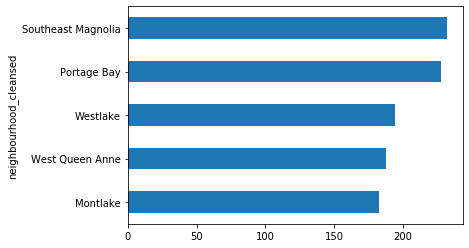

In [20]:
group_by_neighbourhood_df = df_formatted.groupby("neighbourhood_cleansed")["price"].mean().sort_values(ascending=True)
print("Highest Average Price by Neighbourhood")
group_by_neighbourhood_df[-5:].plot.barh(x='price',y='neighbourhood_cleansed');

#### Answer:

Neighbourhood that has highest average price is <b> Southeast Magnolia</b>.

### 3. Is there any correlation between number of listing (at neighbourhood area) and price?

To answer this question, we could use the same approach (to get and clean data) that we did to answer question no 2

In [21]:
df = pd.read_csv('Seattle Airbnb/listings.csv')

# get necessary columns
df = df[["id","neighbourhood_cleansed","price"]]

In [22]:
df_formatted = df.copy()

# extract price and change the type
df_formatted["price"] = df_formatted["price"].replace('[\$,]', '', regex=True).astype(float)

In [23]:
df_result = df_formatted.groupby("neighbourhood_cleansed").agg({'id':'count', 
                         'price':'mean'}).reset_index()
df_result.columns=["neighbourhood_cleansed","total_listing","average_price"]
df_result.head()

,neighbourhood_cleansed,total_listing,average_price
0,Adams,70,121.671429
1,Alki,42,171.619048
2,Arbor Heights,5,126.800000
3,Atlantic,53,111.396226
4,Belltown,234,162.893162


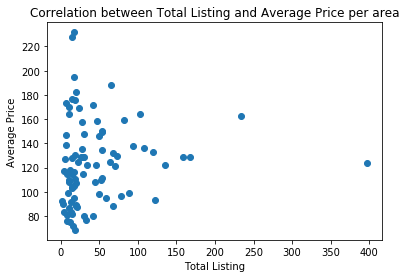

In [24]:
plt.scatter(df_result["total_listing"], df_result["average_price"])
plt.title('Correlation between Total Listing and Average Price per area')
plt.xlabel('Total Listing')
plt.ylabel('Average Price')

plt.show();

In [25]:
df_result.corr()

,total_listing,average_price
total_listing,1.000000,0.098698
average_price,0.098698,1.000000


#### Answer:
We could see on the scatter plot and correlation matrix above that <b>correlation between Total Listing and Average Price is quite low</b>.

### 4. Could we create model to predict price of the listing, given: location (neighbourhood), property type, room type, number of accomodated people (accomodates), number of bathrooms, number of bedrooms, number of beds, bed type, and amenities?

In [26]:
df = pd.read_csv('Seattle Airbnb/listings.csv')

In [27]:
focused_columns = ["host_id","neighbourhood_cleansed","property_type","room_type","accommodates","bathrooms",
           "bedrooms","beds","bed_type","amenities","price"]

In [28]:
focused_df = df[focused_columns]
focused_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_id                 3818 non-null   int64  
 1   neighbourhood_cleansed  3818 non-null   object 
 2   property_type           3817 non-null   object 
 3   room_type               3818 non-null   object 
 4   accommodates            3818 non-null   int64  
 5   bathrooms               3802 non-null   float64
 6   bedrooms                3812 non-null   float64
 7   beds                    3817 non-null   float64
 8   bed_type                3818 non-null   object 
 9   amenities               3818 non-null   object 
 10  price                   3818 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 328.2+ KB


### Remove null

since our null data is not much (less than 1%), let's remove them

In [29]:
focused_df = focused_df.dropna()
focused_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3795 entries, 0 to 3817
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_id                 3795 non-null   int64  
 1   neighbourhood_cleansed  3795 non-null   object 
 2   property_type           3795 non-null   object 
 3   room_type               3795 non-null   object 
 4   accommodates            3795 non-null   int64  
 5   bathrooms               3795 non-null   float64
 6   bedrooms                3795 non-null   float64
 7   beds                    3795 non-null   float64
 8   bed_type                3795 non-null   object 
 9   amenities               3795 non-null   object 
 10  price                   3795 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 355.8+ KB


### Features Engineering

In [30]:
focused_df.head()

,host_id,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price
0,956883,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$85.00
1,5177328,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",$150.00
2,16708587,West Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",$975.00
3,9851441,West Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",$100.00
4,1452570,West Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",$450.00


As usual, we need to extract the price value

In [31]:
focused_df["price"] = focused_df["price"].replace('[\$,]', '', regex=True).astype(float)

Then, we need to extract amenity in amenities column so that we could use it for modeling

In [32]:
def extract_amenities(x):
    x = x.replace("{","")
    x = x.replace("}","")
    x = x.replace("\"","")
    return x
    

focused_df["amenities_formatted"] = focused_df["amenities"].apply(lambda x: extract_amenities(x))

# get all available amenities
amenities_set = set()

amn_list = focused_df['amenities_formatted'].str.split(',').to_list()
for amn_l in amn_list:
    for amn in amn_l:
        if (len(amn)>1):
            amenities_set.add(amn)

# output amenities availability on different columns
for amenities in amenities_set:
    focused_df['has_'+amenities] = focused_df['amenities'].apply(lambda x: amenities in x)
    
focused_df.head()

,host_id,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,amenities_formatted,has_Heating,has_Dryer,has_Wireless Internet,has_Cable TV,has_Shampoo,has_Wheelchair Accessible,has_Breakfast,has_Elevator in Building,has_Gym,has_Family/Kid Friendly,has_Buzzer/Wireless Intercom,has_Other pet(s),has_Dog(s),has_Washer,has_Air Conditioning,has_24-Hour Check-in,has_Smoke Detector,has_Kitchen,has_Iron,has_Hot Tub,has_Hair Dryer,has_Safety Card,has_Fire Extinguisher,has_Lock on Bedroom Door,has_Washer / Dryer,has_Carbon Monoxide Detector,has_Doorman,has_Free Parking on Premises,has_Laptop Friendly Workspace,has_TV,has_Essentials,has_Smoking Allowed,has_Internet,has_Indoor Fireplace,has_Pool,has_First Aid Kit,has_Cat(s),has_Hangers,has_Pets Allowed,has_Suitable for Events,has_Pets live on this property
0,956883,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",True,True,True,True,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False
1,5177328,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,"TV,Internet,Wireless Internet,Kitchen,Free Par...",True,True,True,False,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,True,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,False,False
2,16708587,West Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",True,True,True,True,True,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,False,False,False,False,False,True,False,True,False,True,True,False,True,True,False,False,True,False,True,False,True
3,9851441,West Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,"Internet,Wireless Internet,Kitchen,Indoor Fire...",True,True,True,False,True,False,False,False,False,True,False,False,False,True,False,False,True,True,False,False,False,True,True,False,False,True,False,False,False,False,True,False,True,True,False,False,False,False,False,False,False
4,1452570,West Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,"TV,Cable TV,Internet,Wireless Internet,Kitchen...",True,False,True,True,True,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False


we need to do "one hot encoding" for categorical variables: neighbourhood_cleansed, property_type, room_type, bed_type

In [33]:
focused_df = pd.concat([focused_df, pd.get_dummies(focused_df['neighbourhood_cleansed'],prefix='nc_')], axis=1)
focused_df = pd.concat([focused_df, pd.get_dummies(focused_df['property_type'],prefix='pt_')], axis=1)
focused_df = pd.concat([focused_df, pd.get_dummies(focused_df['room_type'],prefix='rt_')], axis=1)
focused_df = pd.concat([focused_df, pd.get_dummies(focused_df['bed_type'],prefix='bt_')], axis=1)
focused_df.head()

,host_id,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,amenities_formatted,has_Heating,has_Dryer,has_Wireless Internet,has_Cable TV,has_Shampoo,has_Wheelchair Accessible,has_Breakfast,has_Elevator in Building,has_Gym,has_Family/Kid Friendly,has_Buzzer/Wireless Intercom,has_Other pet(s),has_Dog(s),has_Washer,has_Air Conditioning,has_24-Hour Check-in,has_Smoke Detector,has_Kitchen,has_Iron,has_Hot Tub,has_Hair Dryer,has_Safety Card,has_Fire Extinguisher,has_Lock on Bedroom Door,has_Washer / Dryer,has_Carbon Monoxide Detector,has_Doorman,has_Free Parking on Premises,has_Laptop Friendly Workspace,has_TV,has_Essentials,has_Smoking Allowed,has_Internet,has_Indoor Fireplace,has_Pool,has_First Aid Kit,has_Cat(s),has_Hangers,has_Pets Allowed,has_Suitable for Events,has_Pets live on this property,nc__Adams,nc__Alki,nc__Arbor Heights,nc__Atlantic,nc__Belltown,nc__Bitter Lake,nc__Briarcliff,nc__Brighton,nc__Broadview,nc__Broadway,nc__Bryant,nc__Cedar Park,nc__Central Business District,nc__Columbia City,nc__Crown Hill,nc__Dunlap,nc__East Queen Anne,nc__Eastlake,nc__Fairmount Park,nc__Fauntleroy,nc__First Hill,nc__Fremont,nc__Gatewood,nc__Genesee,nc__Georgetown,nc__Green Lake,nc__Greenwood,nc__Haller Lake,nc__Harrison/Denny-Blaine,nc__High Point,nc__Highland Park,nc__Holly Park,nc__Industrial District,nc__Interbay,nc__International District,nc__Laurelhurst,nc__Lawton Park,nc__Leschi,nc__Lower Queen Anne,nc__Loyal Heights,nc__Madison Park,nc__Madrona,nc__Mann,nc__Maple Leaf,nc__Matthews Beach,nc__Meadowbrook,nc__Mid-Beacon Hill,nc__Minor,nc__Montlake,nc__Mount Baker,nc__North Admiral,nc__North Beach/Blue Ridge,nc__North Beacon Hill,nc__North College Park,nc__North Delridge,nc__North Queen Anne,nc__Olympic Hills,nc__Phinney Ridge,nc__Pike-Market,nc__Pinehurst,nc__Pioneer Square,nc__Portage Bay,nc__Rainier Beach,nc__Ravenna,nc__Riverview,nc__Roosevelt,nc__Roxhill,nc__Seaview,nc__Seward Park,nc__South Beacon Hill,nc__South Delridge,nc__South Lake Union,nc__South Park,nc__Southeast Magnolia,nc__Stevens,nc__Sunset Hill,nc__University District,nc__Victory Heights,nc__View Ridge,nc__Wallingford,nc__Wedgwood,nc__West Queen Anne,nc__West Woodland,nc__Westlake,nc__Whittier Heights,nc__Windermere,nc__Yesler Terrace,pt__Apartment,pt__Bed & Breakfast,pt__Boat,pt__Bungalow,pt__Cabin,pt__Camper/RV,pt__Chalet,pt__Condominium,pt__Dorm,pt__House,pt__Loft,pt__Other,pt__Tent,pt__Townhouse,pt__Treehouse,pt__Yurt,rt__Entire home/apt,rt__Private room,rt__Shared room,bt__Airbed,bt__Couch,bt__Futon,bt__Pull-out Sofa,bt__Real Bed
0,956883,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,"TV,Cable TV,Internet,Wireless Internet,Air Con...",True,True,True,True,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,5177328,West Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,"TV,Internet,Wireless Internet,Kitchen,Free Par...",True,True,True,False,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,True,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,16708587,West Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Inter

### Prepare Training & Test Dataset

In [34]:
for_ml_df = focused_df.select_dtypes(exclude=['object']).set_index('host_id')
for_ml_df.head()

,accommodates,bathrooms,bedrooms,beds,price,has_Heating,has_Dryer,has_Wireless Internet,has_Cable TV,has_Shampoo,has_Wheelchair Accessible,has_Breakfast,has_Elevator in Building,has_Gym,has_Family/Kid Friendly,has_Buzzer/Wireless Intercom,has_Other pet(s),has_Dog(s),has_Washer,has_Air Conditioning,has_24-Hour Check-in,has_Smoke Detector,has_Kitchen,has_Iron,has_Hot Tub,has_Hair Dryer,has_Safety Card,has_Fire Extinguisher,has_Lock on Bedroom Door,has_Washer / Dryer,has_Carbon Monoxide Detector,has_Doorman,has_Free Parking on Premises,has_Laptop Friendly Workspace,has_TV,has_Essentials,has_Smoking Allowed,has_Internet,has_Indoor Fireplace,has_Pool,has_First Aid Kit,has_Cat(s),has_Hangers,has_Pets Allowed,has_Suitable for Events,has_Pets live on this property,nc__Adams,nc__Alki,nc__Arbor Heights,nc__Atlantic,nc__Belltown,nc__Bitter Lake,nc__Briarcliff,nc__Brighton,nc__Broadview,nc__Broadway,nc__Bryant,nc__Cedar Park,nc__Central Business District,nc__Columbia City,nc__Crown Hill,nc__Dunlap,nc__East Queen Anne,nc__Eastlake,nc__Fairmount Park,nc__Fauntleroy,nc__First Hill,nc__Fremont,nc__Gatewood,nc__Genesee,nc__Georgetown,nc__Green Lake,nc__Greenwood,nc__Haller Lake,nc__Harrison/Denny-Blaine,nc__High Point,nc__Highland Park,nc__Holly Park,nc__Industrial District,nc__Interbay,nc__International District,nc__Laurelhurst,nc__Lawton Park,nc__Leschi,nc__Lower Queen Anne,nc__Loyal Heights,nc__Madison Park,nc__Madrona,nc__Mann,nc__Maple Leaf,nc__Matthews Beach,nc__Meadowbrook,nc__Mid-Beacon Hill,nc__Minor,nc__Montlake,nc__Mount Baker,nc__North Admiral,nc__North Beach/Blue Ridge,nc__North Beacon Hill,nc__North College Park,nc__North Delridge,nc__North Queen Anne,nc__Olympic Hills,nc__Phinney Ridge,nc__Pike-Market,nc__Pinehurst,nc__Pioneer Square,nc__Portage Bay,nc__Rainier Beach,nc__Ravenna,nc__Riverview,nc__Roosevelt,nc__Roxhill,nc__Seaview,nc__Seward Park,nc__South Beacon Hill,nc__South Delridge,nc__South Lake Union,nc__South Park,nc__Southeast Magnolia,nc__Stevens,nc__Sunset Hill,nc__University District,nc__Victory Heights,nc__View Ridge,nc__Wallingford,nc__Wedgwood,nc__West Queen Anne,nc__West Woodland,nc__Westlake,nc__Whittier Heights,nc__Windermere,nc__Yesler Terrace,pt__Apartment,pt__Bed & Breakfast,pt__Boat,pt__Bungalow,pt__Cabin,pt__Camper/RV,pt__Chalet,pt__Condominium,pt__Dorm,pt__House,pt__Loft,pt__Other,pt__Tent,pt__Townhouse,pt__Treehouse,pt__Yurt,rt__Entire home/apt,rt__Private room,rt__Shared room,bt__Airbed,bt__Couch,bt__Futon,bt__Pull-out Sofa,bt__Real Bed
host_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
956883,4,1.0,1.0,1.0,85.0,True,True,True,True,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
5177328,4,1.0,1.0,1.0,150.0,True,True,True,False,False,False,False,False,False,True,True,False,False,True,False,False,True,True,False,False,False,True,True,False,False,True,False,True,False,True,True,False,True,False,False,True,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
16708587,11,4.5,5.0,7.0,975.0,True,True,True,True,True,False,False,False,False,True,False,False,True,True,True,False,True,True,False,True,False,False,False,False,False,True,False,True,False,True,True,False,True,True,False,False,True,False,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [35]:
X = for_ml_df.drop(columns=["price"])
y = for_ml_df["price"]

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=20, test_size=0.3)

### Training

In [37]:
regr = RandomForestRegressor(max_depth=5, n_estimators=100)

regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

### Evaluation

In [38]:
from sklearn.metrics import mean_absolute_error

y_pred_train = regr.predict(X_train)
print("Train MAE: ",mean_absolute_error(y_train, y_pred_train))
y_pred_test = regr.predict(X_test)
print("Test MAE: ",mean_absolute_error(y_test, y_pred_test))

Train MAE:  32.85584985096041
Test MAE:  36.42456476921319


### Answer

We could <b>create price prediction model using those features, with Mean Absolute Error around $36</b> (from Test Dataset).
We also could recommend the host <b>to increase price on weekend by 4-5%</b>.

However I think that MAE (Mean Absolute Error) could be improved if we add more data or more features.